In [1]:
# Shift + Enter to run the current cell
print('Hello World')

Hello World


# This is an example Marakdown cell
This is nice to write down instructions and format text with title, **bold** and _italic_

You can change the cell type in the top bar menu

# Datasets
#### finger 
link = https://www.bbci.de/competition/download/competition_iv/BCICIV_4_mat.zip
eval = https://www.bbci.de/competition/iv/results/ds4/true_labels.zip

#### foot tracking
download page: http://neurotycho.org/expdatalist/listview?task=36


# Part 0 : import libraries

In [2]:
# Import packages

import numpy as np # library providing efficient array manipulation
import sklearn # machine learning tools
import matplotlib.pyplot as plt # matlab-like plot library
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA

from scipy.signal import iirdesign, sosfilt, convolve, wiener

import tp # load python module written for this project

# Part 0 : Dataset

ECoG dataset of finger tapping, more details here: https://www.bbci.de/competition/iv/desc_4.pdf

### Download dataset


In [3]:
dataset_path = 'data/bciciv'
if not tp.dataset_exists(dataset_path):
    tp.download_dataset(dataset_path)
else:
    print(f'dataset already exists in {dataset_path}') 


dataset already exists in data/bciciv


### Load dataset

In [4]:
dataset = tp.load_data(dataset_path)
print(dataset)
fs = 1000

### Explore dataset

In [5]:
for subject in dataset:
    print(subject)

In [6]:
print(len(dataset))

3


In [7]:
subject0 = dataset[0] # first subject in dataset
print(subject0.train_fingers)

[[-0.40011286  0.1732757   0.99956459 -0.06184273  0.41964019]
 [-0.40011286  0.1732757   0.99956459 -0.06184273  0.41964019]
 [-0.40011286  0.1732757   0.99956459 -0.06184273  0.41964019]
 ...
 [-0.61251224 -0.34792878 -0.21741923 -0.17560933 -0.07191979]
 [-0.61251224 -0.34792878 -0.21741923 -0.17560933 -0.07191979]
 [-0.61251224 -0.34792878 -0.21741923 -0.17560933 -0.07191979]]


In [8]:
subject0.train_fingers.shape

(400000, 5)

In [9]:
# get first sample for all fingers, indexing starts at 0 /!\
subject0.train_fingers[0, :]

array([-0.40011286,  0.1732757 ,  0.99956459, -0.06184273,  0.41964019])

In [10]:
subject0.train_fingers[-1, :] # get last sample for all fingers

array([-0.61251224, -0.34792878, -0.21741923, -0.17560933, -0.07191979])

In [11]:
subject0.train_fingers[1200:1300, 4] # get 100 samples from index 1200 to 1299 for the 5th finger

array([0.41964019, 0.41964019, 0.41964019, 0.41964019, 0.41964019,
       0.41964019, 0.41964019, 0.41964019, 0.41964019, 0.41964019,
       0.41964019, 0.41964019, 0.41964019, 0.41964019, 0.41964019,
       0.41964019, 0.41964019, 0.41964019, 0.41964019, 0.41964019,
       0.41964019, 0.41964019, 0.41964019, 0.41964019, 0.41964019,
       0.41964019, 0.41964019, 0.41964019, 0.41964019, 0.41964019,
       0.41964019, 0.41964019, 0.41964019, 0.41964019, 0.41964019,
       0.41964019, 0.41964019, 0.41964019, 0.41964019, 0.41964019,
       0.41964019, 0.41964019, 0.41964019, 0.41964019, 0.41964019,
       0.41964019, 0.41964019, 0.41964019, 0.41964019, 0.41964019,
       0.41964019, 0.41964019, 0.41964019, 0.41964019, 0.41964019,
       0.41964019, 0.41964019, 0.41964019, 0.41964019, 0.41964019,
       0.41964019, 0.41964019, 0.41964019, 0.41964019, 0.41964019,
       0.41964019, 0.41964019, 0.41964019, 0.41964019, 0.41964019,
       0.41964019, 0.41964019, 0.41964019, 0.41964019, 0.41964

#### Plot the data with matplotlib
You can find the documentation for the `plot` function here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

For more information, you can check the [quick start guide](https://matplotlib.org/stable/users/explain/quick_start.html)

Text(0.5, 0.98, 'Finger trajectories (train set)')

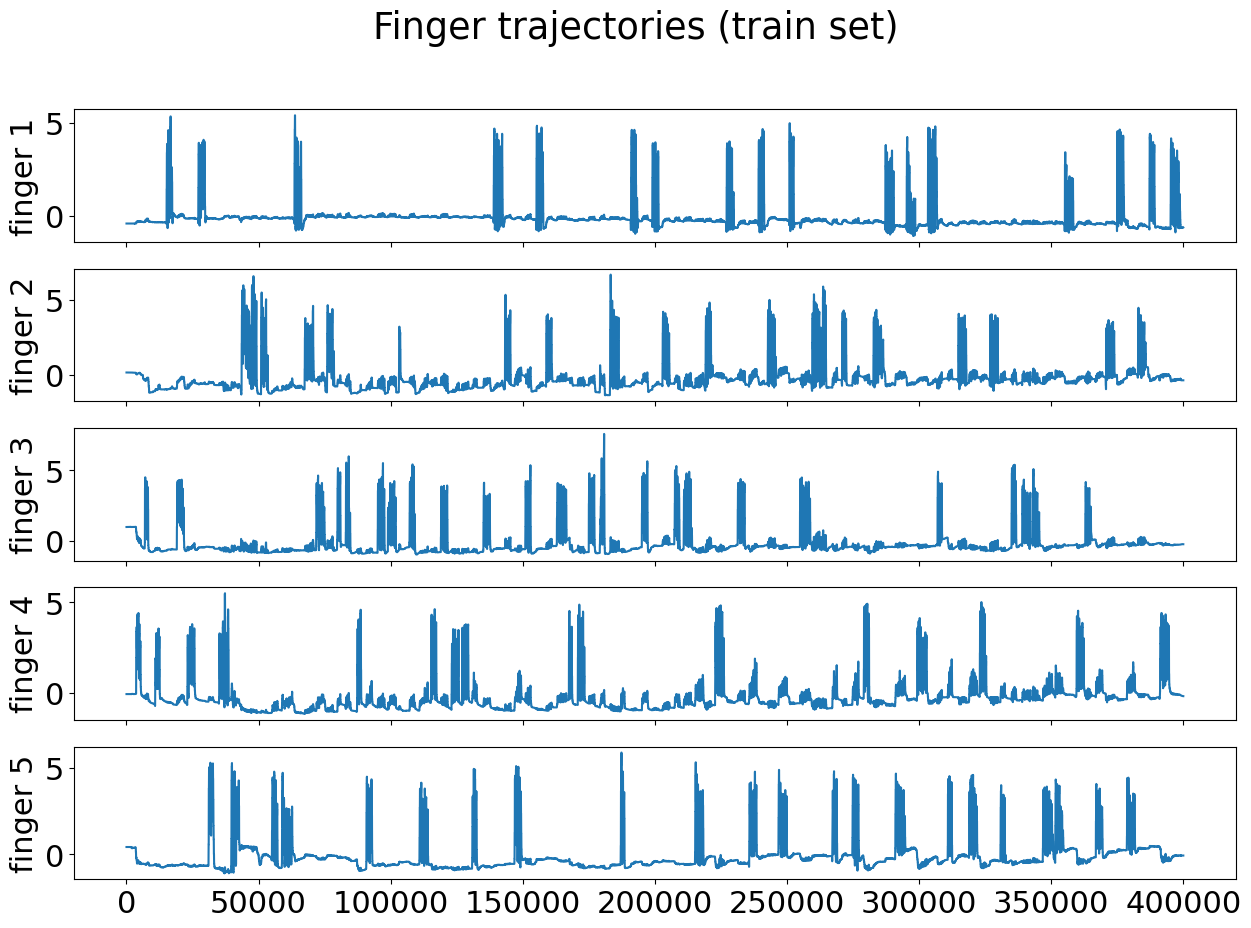

In [12]:
n_fingers = subject0.train_fingers.shape[1]

fig = plt.figure(figsize=(15,10))
axes = fig.subplots(n_fingers, 1, sharex=True)

for i in range(n_fingers):
    axes[i].plot(subject0.train_fingers[:,i])
    axes[i].set_ylabel(f'finger {i+1}')

fig.suptitle('Finger trajectories (train set)')

Text(0.5, 0.98, 'Finger trajectories (test set)')

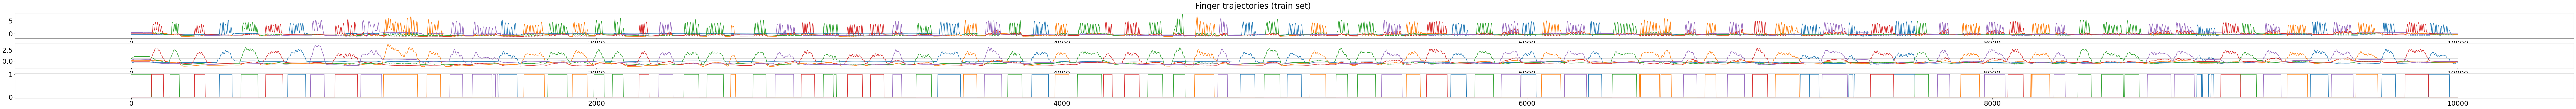

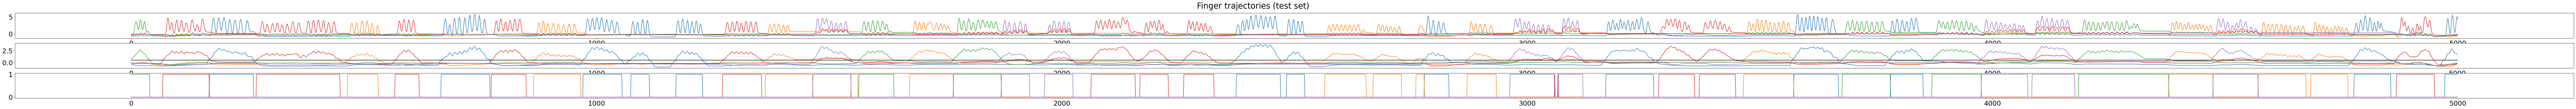

In [13]:
subject_data = subject0

f_ratio = 40
(n_times_train, n_fingers) = subject_data.train_fingers.shape
n_times_train = n_times_train//f_ratio
threshold = 0.5
n_times_test = subject_data.test_fingers.shape[0]//f_ratio

win_size = 25
win = 1/win_size*np.ones([win_size, 1])
train_fingers_filtered = convolve(subject_data.train_fingers[::f_ratio], win, 'same')
train_fingers_filtered = np.concatenate((train_fingers_filtered, threshold*np.ones([n_times_train, 1])), axis=1)
y_train = np.argmax(train_fingers_filtered, axis=1)
cue_train = np.zeros([n_times_train, n_fingers+1])
for i in range(n_times_train):
    cue_train[i, y_train[i]] = 1

test_fingers_filtered = convolve(subject_data.test_fingers[::f_ratio], win, 'same')
test_fingers_filtered = np.concatenate((test_fingers_filtered, threshold*np.ones([n_times_test, 1])), axis=1)
y_test = np.argmax(test_fingers_filtered, axis=1)
cue_test = np.zeros([n_times_test, n_fingers+1])
for i in range(n_times_test):
    cue_test[i, y_test[i]] = 1

# Save the full data for future use
y_train_full = y_train
y_test_full = y_test

fig = plt.figure(figsize=(150,5))
ax = fig.subplots(3, 1)
for i in range(n_fingers):
    ax[0].plot(subject_data.train_fingers[::f_ratio, i])
    ax[1].plot(train_fingers_filtered[:, i])
    ax[2].plot(cue_train[:, i])
ax[1].plot([0, n_times_train], [threshold, threshold], color='k')
fig.suptitle('Finger trajectories (train set)')


fig = plt.figure(figsize=(150,5))
ax = fig.subplots(3, 1)
for i in range(n_fingers):
    ax[0].plot(subject_data.test_fingers[::f_ratio, i])
    ax[1].plot(test_fingers_filtered[:, i])
    ax[2].plot(cue_test[:, i])
ax[1].plot([0, n_times_test], [threshold, threshold], color='k')
fig.suptitle('Finger trajectories (test set)')

# click on the figure to expand

Text(0.5, 0.98, 'First ecog channel (train set)')

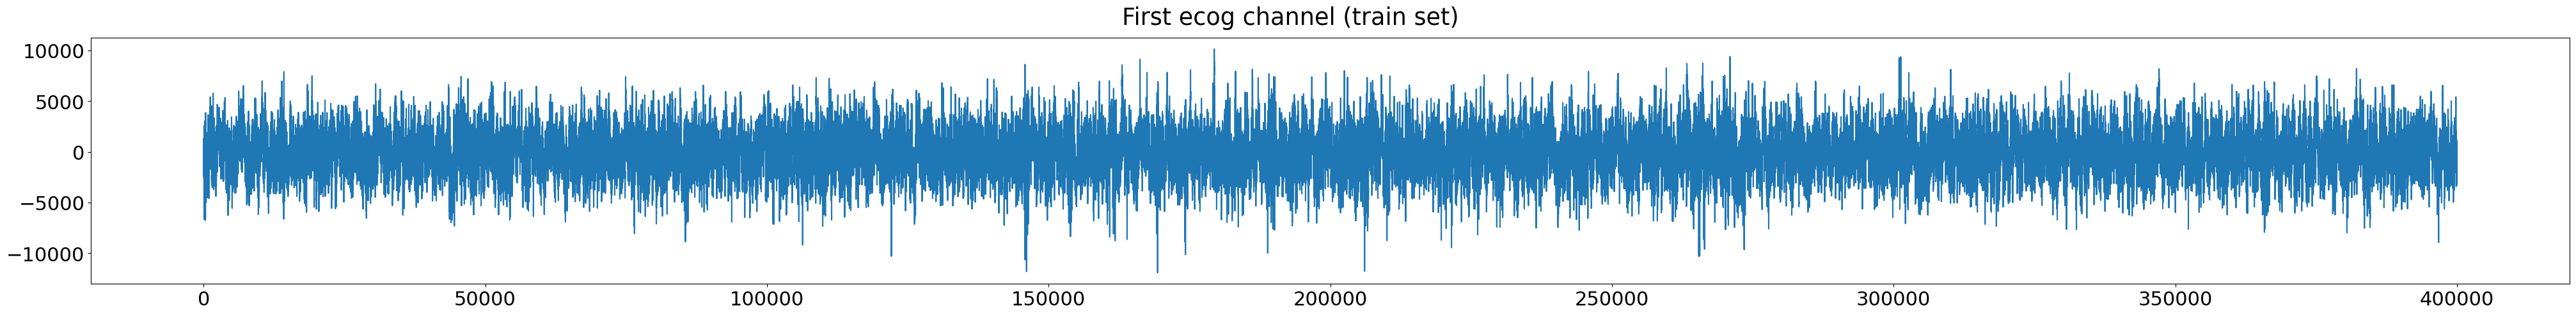

In [14]:
n_channels = subject0.train_ecog.shape[1]


fig = plt.figure(figsize=(50,5))
ax = fig.subplots()

ax.plot(subject0.train_ecog[:, 0])

fig.suptitle('First ecog channel (train set)')

# Part 1 : Dicrete decoding

In this part we will be interested in decoding finger mouvement during tapping from ECOG data and in order to do so we will focus on several main points of data processing such as 
- Pre-processing - where we will see artefact removal for example
- Feature extraction - by extracting time-frequency features on every electrodes using short term fourier transfrom
- Feature reduction using PCA

After this first part we will focus on classification paradigms with
- Cross validation in order to ensure the robustness of our testing procedure
- Classification using an LDA classifier with or without a validation set.

Finally we will evaluate the model accuracy and learn to use different metrics mainly on confusion matrices. 

## 1.1 Data pre-processing

### Artefact removal 

In [15]:
subject_data = subject0

### Feature extraction

Text(0.5, 0.98, 'Filtered data (train set)')

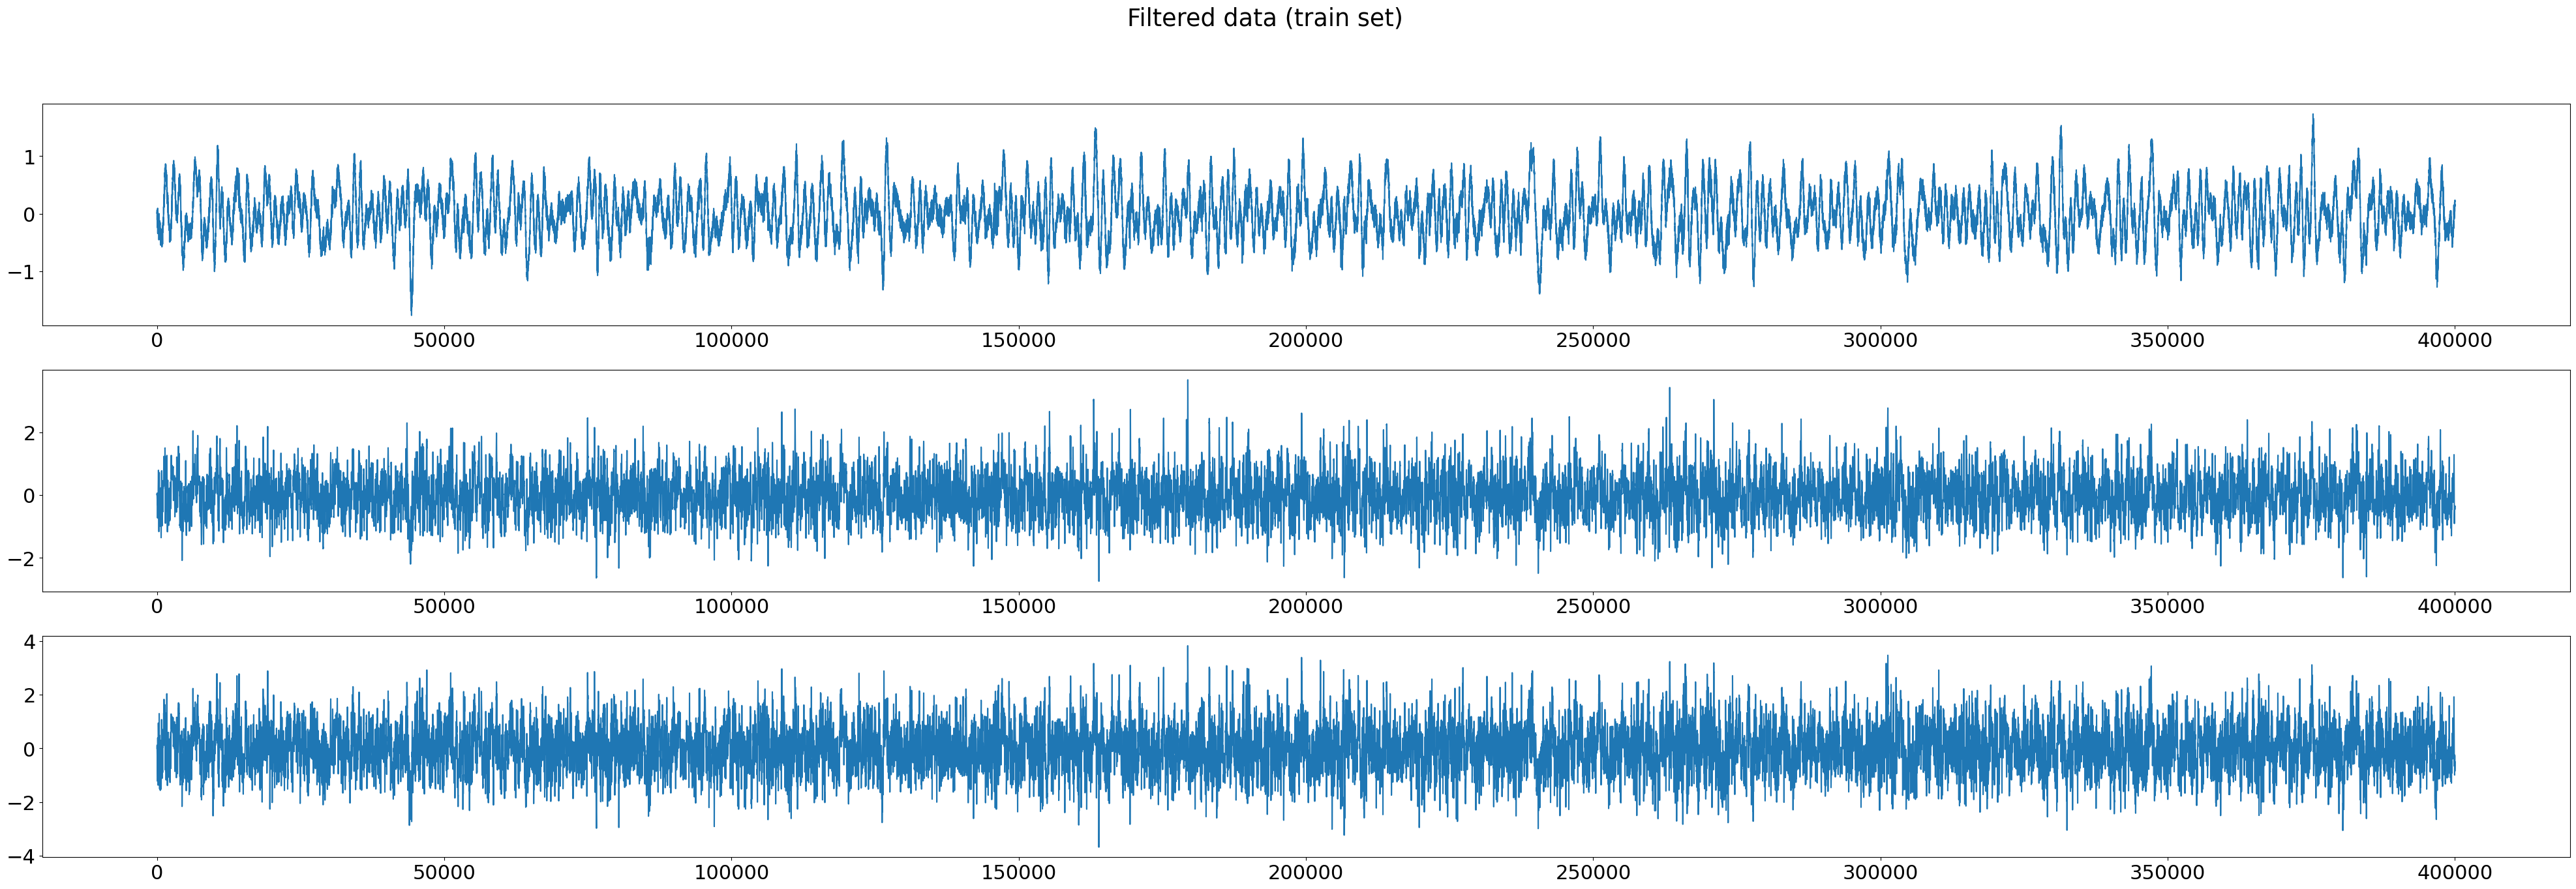

In [59]:
# bands = [(1, 60), (60, 100), (100, 200)]
bands = [(1, 10)]
for i in range(1, 20):
    bands.append((i*10, (i+1)*10))
filters = []

for i_band, band in enumerate(bands):
    filters.append(iirdesign(band[0], band[1], 2, 20, analog=False, fs=fs, output='sos'))

scaler = StandardScaler()
train_ecog_normalized = scaler.fit_transform(subject_data.train_ecog)
test_ecog_normalized = scaler.fit_transform(subject_data.test_ecog)

train_ecog_filtered = []
test_ecog_filtered = []

for filt in filters:
    train_ecog_filtered.append(sosfilt(filt, train_ecog_normalized, axis=0))
    test_ecog_filtered.append(sosfilt(filt, test_ecog_normalized, axis=0))

fig = plt.figure(figsize=(50,15))
ax = fig.subplots(nrows=3, ncols=1)

ax[0].plot(train_ecog_filtered[0][:, 0])
ax[1].plot(train_ecog_filtered[1][:, 0])
ax[2].plot(train_ecog_filtered[2][:, 0])

fig.suptitle('Filtered data (train set)')

Extract power in 40 ms

In [60]:
win_size = 1000
win = 1/win_size*np.ones([win_size, 1])

wiener_win_size = 25

train_average_power = []
for train_ecog in train_ecog_filtered:
    train_average_power.append(convolve(np.power(train_ecog, 2), win, 'same'))
    
X_train = np.concatenate(train_average_power, axis=1)
X_train = X_train[::f_ratio] # Because of the 25Hz of the gloves again
X_train_full = X_train
# for i in range(X_train.shape[1]):
#     X_train[:, i] = wiener(X_train[:, i], wiener_win_size)
    


test_average_power = []
for test_ecog in test_ecog_filtered:
    test_average_power.append(convolve(np.power(test_ecog, 2), win, 'same'))
X_test = np.concatenate(test_average_power, axis=1)
X_test = X_test[::f_ratio] # Because of the 25Hz of the gloves again
X_test_full = X_test
# for i in range(X_train.shape[1]):
#     X_train[:, i] = wiener(X_train[:, i], wiener_win_size)

### Set if we use the idle or not

In [91]:

use_idle_data = True
if not use_idle_data:
    X_train = X_train_full[y_train_full != 5]
    X_test = X_test_full[y_test_full != 5]
    y_train = y_train_full[y_train_full != 5]
    y_test = y_test_full[y_test_full != 5]
else:
    X_train = X_train_full
    X_test = X_test_full
    y_train = y_train_full
    y_test = y_test_full
    

## 1.2 Classification

### Train-test and cross-validation 

### Get the predicted labels

In [92]:
estimator = LDA()

estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
y_proba = estimator.predict_proba(X_test)

Text(0.5, 0.98, 'Finger trajectories (test set)')

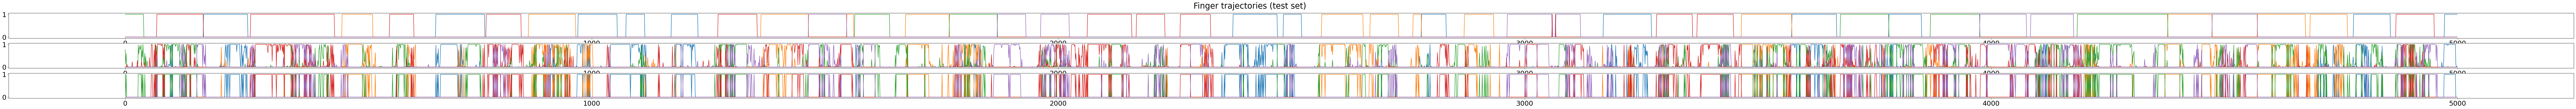

In [93]:
# y_pred = np.int_(5*np.ones(n_times_test))
# y_pred[test_no_idle] = y_pred
cue_pred = np.zeros([n_times_test, n_fingers+1])
for i in range(n_times_test):
    cue_pred[i, y_pred[i]] = 1

fig = plt.figure(figsize=(150,5))
ax = fig.subplots(3, 1)
for i in range(n_fingers):
    ax[0].plot(cue_test[:, i])
    ax[1].plot(y_proba[:, i])
    ax[2].plot(cue_pred[:, i])
fig.suptitle('Finger trajectories (test set)')

### The confusion matrix

The confusion matrix represents how well our classifier is performing. The line are the true labels we are expected to obtain and the columns are the labels our classifier actually gives us. 

<Figure size 10000x10000 with 0 Axes>

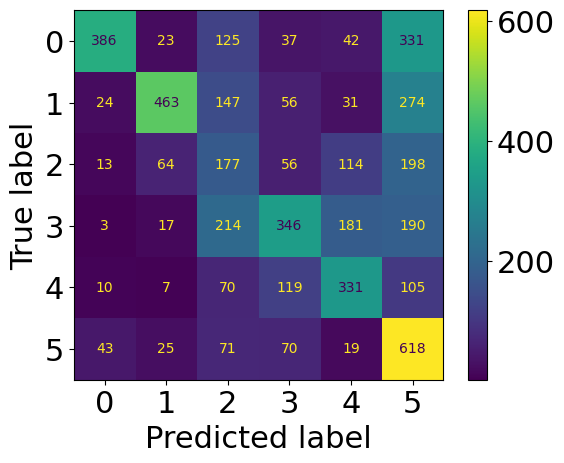

In [94]:
fig = plt.figure(figsize=(100,100))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw={'fontsize': 10})

### The accuracy and the balanced accuracy

A good way to consider how well the classifer is performing using the confusion matrix is the accuracy. The accuracy is equal to the total number of well predicted labels divided by the total number of labels. In the confusion matrix it is equal to the sum of the diagonal divided by the sum of all the elements of the matrix. 


In [95]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy is {:.2f}%. Chance is at {:.2f}%".format(100*np.mean(acc), 100/np.unique(y_test).shape[0]))

Accuracy is 46.42%. Chance is at 16.67%


In [96]:
acc = balanced_accuracy_score(y_test, y_pred)
print("Average score is {:.2f}%. Chance is at {:.2f}%".format(100*np.mean(acc), 100/np.unique(y_test).shape[0]))

Average score is 46.14%. Chance is at 16.67%


### Feature selection and dimensionality reduction

In [97]:
X_train_pca = []
X_test_pca = []
for i in range(n_fingers):
    s_filt = PCA(10)
    s_filt.fit(X_train[y_train==i])
    X_train_pca.append(s_filt.transform(X_train))
    X_test_pca.append(s_filt.transform(X_test))

X_train_pca = np.concatenate(X_train_pca, axis=1)
X_test_pca = np.concatenate(X_test_pca, axis=1)

estimator.fit(X_train_pca, y_train)
y_pred_pca = estimator.predict(X_test_pca)

Average score is 23.41%. Chance is at 16.67%


<Figure size 10000x10000 with 0 Axes>

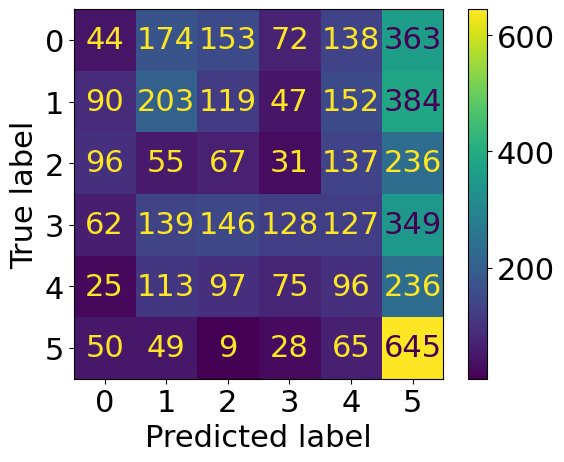

In [100]:
fig = plt.figure(figsize=(100,100))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pca)

acc = balanced_accuracy_score(y_test, y_pred_pca)
print("Average score is {:.2f}%. Chance is at {:.2f}%".format(100*np.mean(acc), 100/np.unique(y_test).shape[0]))

In [99]:
X_train.shape

(10000, 1240)

### Using the validation set

### Classification

### Using the validation set

## 1.3 Metrics and confusion matrix

### The confusion matrix

### The accuracy

### Other metrics (recall, precision, balanced accuracy, F-score, gmean...)

### ROC Curve ?

In [ ]:
win = np.ones([1000, 1])
y_pred2 = np.argmax(convolve(y_proba, win, 'same'), axis=1)

y_pred = np.int_(5*np.ones(n_times_test))
y_pred[test_no_idle] = y_pred2
cue_pred = np.zeros([n_times_test, n_fingers+1])
for i in range(n_times_test):
    cue_pred[i, y_pred[i]] = 1

fig = plt.figure(figsize=(150,5))
ax = fig.subplots(2, 1)
for i in range(n_fingers):
    ax[0].plot(cue_test[:, i])
    ax[1].plot(cue_pred[:, i])
fig.suptitle('Finger trajectories (test set)')

In [ ]:

fig = plt.figure(figsize=(100,100))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred2)

acc = balanced_accuracy_score(y_test, y_pred2)
print("Average score is {:.2f}%. Chance is at {:.2f}%".format(100*np.mean(acc), 100/6))

# Part 2 : Continuous decoding

In this part we will be interested in decoding precise hand movements of a monkey from ECOG data and in order to do so we will procede just as in the Part 1 with
- Pre-processing - where we will see artefact removal for example
- Feature extraction - by extracting time-frequency features on every electrodes using short term fourier transfrom
- Feature reduction using PCA

After this first part we will focus on classification paradigms with
- Cross validation in order to ensure the robustness of our testing procedure
- Regression using a linear model 

Finally we will evaluate the model performances using mean square error or correlation.

## 1.1 Data pre-processing

### Artefact removal 

### Feature extraction

### Feature selection and dimensionality reduction

## 1.2 Classification

### Train-test and cross-validation 

### Get the predicted labels

### Using the validation set

## 1.3 Metrics for continuous decoding

### RMSE

### Correlation